## GPT Text Classification
#### Let's read last week's Text DataFrame

In [20]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/2023-12-01-Export-Posts-Text-Master.csv')

In [21]:
df.head()

,Unnamed: 0,shortcode,Text,Text Type,Policy Issues
0,0,CyMAe_tufcR,#Landtagswahl23 🤩🧡🙏 #FREIEWÄHLER #Aiwanger #Da...,Caption,['1. Political parties:\n- FREIEWÄHLER\n- Aiwa...
1,1,CyL975vouHU,Die Landtagswahl war für uns als Liberale hart...,Caption,['Landtagswahl']
2,2,CyL8GWWJmci,Nach einem starken Wahlkampf ein verdientes Er...,Caption,['1. Wahlkampf und Wahlergebnis:\n- Wahlkampf\...
3,3,CyL7wyJtTV5,So viele Menschen am Odeonsplatz heute mit ein...,Caption,"['Israel', 'Terrorismus', 'Hamas', 'Entwicklun..."
4,4,CyLxwHuvR4Y,Herzlichen Glückwunsch zu diesem grandiosen Wa...,Caption,['1. Wahlsieg und Parlamentseinstieg\n- Wahlsi...


#### Setup for GPT

In [1]:
!pip install -q openai backoff gpt-cost-estimator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.4/221.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.


We're using the new Colab Feature to store keys safely within the Colab Environment. Click on the key on the left to add your API key and enable it for this notebook. Enter the name of your API-Key in the `api_key_name` variable.

In [2]:
import openai
from openai import OpenAI
from google.colab import userdata
import backoff
from gpt_cost_estimator import CostEstimator

api_key_name = "openai-lehrstuhl-api"
api_key = userdata.get(api_key_name)

# Initialize OpenAI using the key
client = OpenAI(
    api_key=api_key
)

@CostEstimator()
def query_openai(model, temperature, messages, mock=True, completion_tokens=10):
    return client.chat.completions.create(
                      model=model,
                      temperature=temperature,
                      messages=messages,
                      max_tokens=600)

# We define the run_request method to wrap it with the @backoff decorator
@backoff.on_exception(backoff.expo, (openai.RateLimitError, openai.APIError))
def run_request(system_prompt, user_prompt, model, mock):
  messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": user_prompt}
  ]

  return query_openai(
          model=model,
          temperature=0.0,
          messages=messages,
          mock=mock
        )

Next, we create a system prompt describing what we want to classify. For further examples of prompts and advice on prompt engineering see e.g. [the prompting guide](hhttps://www.promptingguide.ai/techniques/zeroshot) and further resources linked at the bottom of the page.

For the moment we are going to use the prompt from the literature.

Do not forget the **[Prompt Archive](https://uniregensburg-my.sharepoint.com/:x:/g/personal/acm53421_ads_uni-regensburg_de/EVgX8Avwyx5DvRUGugboTCkBMnp-faFsnKhhKvNH34tB-A?e=sYUY9K)** when experimenting. Share your successfull prompt with us!

In [ ]:
system_prompt = """
You are an advanced classifying AI. Your task is to classify the sentiment of a text. Sentiment can be either ‘positive’, ‘negative’, or ‘neutral’.
"""

In [ ]:
prompt = """
Please classify the following social media comment into either ‘negative’, ‘neutral’, or ‘positive’. Your answer MUST be one of [‘negative’, ‘neutral’, ‘positive’], and it should be presented in lowercase.
Text: [TEXT]
"""

#### Running the request.

The following code snippet uses my [gpt-cost-estimator](https://pypi.org/project/gpt-cost-estimator/) package to simulate API requests and calculate a cost estimate. Please run the estimation whne possible to asses the price-tag before sending requests to OpenAI! Make sure `run_request` and `system_prompt` (see *Setup for GPT*) are defined before this block by running the two blocks above! 

Fill in the `MOCK`, `RESET_COST`, `COLUMN`, `SAMPLE_SIZE`, and `MODEL` variables as needed (see comments above each variable.)

In [ ]:
from tqdm.auto import tqdm

#@markdown Do you want to mock the OpenAI request (dry run) to calculate the estimated price?
MOCK = False # @param {type: "boolean"}
#@markdown Do you want to reset the cost estimation when running the query?
RESET_COST = True # @param {type: "boolean"}
#@markdown What's the column name to save the results of the data extraction task to?
COLUMN = 'Sentiment' # @param {type: "string"}
#@markdown Do you want to run the request on a smaller sample of the whole data? (Useful for testing). Enter 0 to run on the whole dataset.
SAMPLE_SIZE = 25 # @param {type: "number", min: 0}

#@markdown Which model do you want to use?
MODEL = "gpt-3.5-turbo-0613" # @param ["gpt-3.5-turbo-0613", "gpt-4-1106-preview", "gpt-4-0613"] {allow-input: true}


# Initializing the empty column
if COLUMN not in df.columns:
  df[COLUMN] = None

# Reset Estimates
CostEstimator.reset()
print("Reset Cost Estimation")

filtered_df = df.copy()

# Skip previously annotated rows
filtered_df = filtered_df[pd.isna(filtered_df[COLUMN])]

if SAMPLE_SIZE > 0:
  filtered_df = filtered_df.sample(SAMPLE_SIZE)

for index, row in tqdm(filtered_df.iterrows(), total=len(filtered_df)):
    try:
        p = prompt.replace('[TEXT]', row['Text'])
        response = run_request(system_prompt, p, MODEL, MOCK)

        if not MOCK:
          # Extract the response content
          # Adjust the following line according to the structure of the response
          r = response.choices[0].message.content

          # Update the 'new_df' DataFrame
          df.at[index, COLUMN] = r

    except Exception as e:
        print(f"An error occurred: {e}")
        # Optionally, handle the error (e.g., by logging or by setting a default value)

print()

Reset Cost Estimation


  0%|          | 0/25 [00:00<?, ?it/s]

Cost: $0.0002 | Total: $0.0069


In [ ]:
df[~pd.isna(df['Sentiment'])].head()

,Unnamed: 0,shortcode,Text,Text Type,Policy Issues,Sentiment
6,6,CyLt56wtNgV,Viele gemischte Gefühle waren das gestern Aben...,Caption,['Demokratie'],negative
27,27,CyKwo3Ft6tp,Swipe dich rückwärts durch die Kampagne ✨\n\n🤯...,Caption,['Soziale Gerechtigkeit'],positive
29,29,CyKwBKcqi31,#FREIEWÄHLER jetzt zweite Kraft in Bayern! Gro...,Caption,"['Stärkung der Demokratie', 'Sorgen der Bürger...",positive
66,66,CyIjC3QogWT,In einer gemeinsamen Erklärung der Parteivorsi...,Caption,['Israel'],positive
212,212,CyAmHU7qlVc,#FREIEWÄHLER #Aiwanger,Caption,NaN,neutral


In [ ]:
# Save Results
df.to_csv('/content/drive/MyDrive/2023-12-01-Export-Posts-Text-Master.csv')

Let's plot the result for a first *big picture*

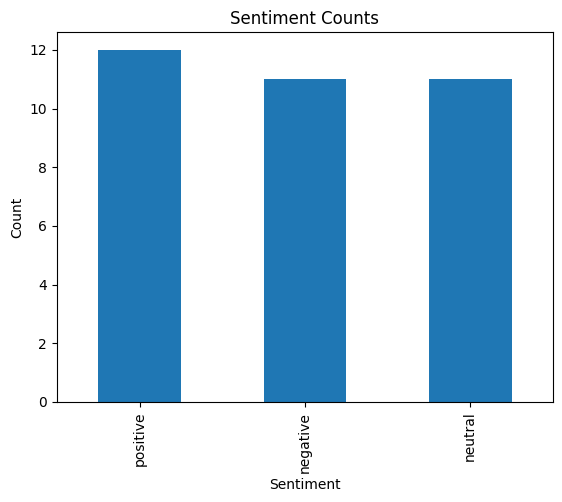

In [ ]:

import matplotlib.pyplot as plt

# Count the occurrences of each sentiment
sentiment_counts = df['Sentiment'].value_counts()

# Create a bar chart
sentiment_counts.plot(kind='bar')

# Adding labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Counts')

# Show the plot
plt.show()